NOTEBOOK - LIMPIO

1 - IMPORTAMOS LIBRERIAS Y LEEMOS LOS DATOS

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as pl
import re
pl.offline.init_notebook_mode(connected=True)

propiedades= pd.read_csv(r'C:\Users\Matías\Documents\DH\properatti.csv')

In [103]:
propiedades.head()

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


COMENZAMOS CON LA LIMPIEZA DE DATOS


In [2]:
#creamos un dataframe nuevo tomando en cuenta solo las propiedades de Capital Federal
propiedades_capital=propiedades.loc[(propiedades.state_name=="Capital Federal")]
propiedades_capital.state_name.value_counts()

Capital Federal    32316
Name: state_name, dtype: int64

In [3]:
#creamos una serie dummy para saber el tipo de cambio utilizado a la fecha del registro
#SOLO DE MANERA INFORMATIVA
dummy=propiedades_capital['price_aprox_local_currency']/propiedades_capital['price_aprox_usd']
tasa_cambio=dummy.mean()
tasa_cambio

17.644499993856833

In [4]:
#chequeamos la cantidad de valores faltantes en la columna price_usd_per_m2
#nos interesa ese campo ya que el precio en moneda local está sujeto a una tasa de cambio muy volatil 
#o inestables en el tiempo (tenemos la tasa de cambio a la fecha que se creo el DF pero no cuando se grabaron los datos 
#de cada propiedad), en este caso nos guiaremos por el valor en USD$ y el area o superficie de la propiedad
propiedades_capital.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2               8882
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
dtype: int64

In [5]:
#creamos una serie nueva tomando el promedio del m2 en dolares con respecto al barrio (lo usaremos posteriormente para llenas los NaN)

pricem2USD_fill_values=propiedades_capital.groupby('place_name').price_usd_per_m2.mean()
pricem2USD_fill_values

place_name
Abasto              2057.529147
Agronomía           2088.124134
Almagro             2749.102521
Balvanera           1982.249390
Barracas            1969.946866
                       ...     
Villa Riachuelo     1110.690766
Villa Santa Rita    1889.186620
Villa Soldati        743.666758
Villa Urquiza       2495.288265
Villa del Parque    2233.837905
Name: price_usd_per_m2, Length: 62, dtype: float64

In [6]:
#creamos un dataFrame nuevo con los valores de la serie obtenida anteriormente y hacemos un merge a propiedades_capital2 en una nueva columna 
#con el promedio del m2 en dolares

pricem2USD_fill_values_df= pd.DataFrame(pricem2USD_fill_values)
pricem2USD_fill_values_df.reset_index(inplace=True)
propiedades_capital2=propiedades_capital.merge(pricem2USD_fill_values_df, on= 'place_name', how='left', suffixes = ("", "_mean"))

#usamos fillna para substituir los NaN con los valores en la columna price_usd_per_m2_mean
propiedades_capital2.price_usd_per_m2.fillna(propiedades_capital2.price_usd_per_m2_mean, inplace = True)

In [7]:
#chequeamos que no existan NaN en price_usd_per_m2
propiedades_capital2.price_usd_per_m2.isna().sum()

0

In [8]:
#hacemos un describe la columna price_usd_per_m2
propiedades_capital2.price_usd_per_m2.describe()

count     32316.000000
mean       3040.608512
std        3230.037746
min          13.797467
25%        2000.000000
50%        2495.288265
75%        3153.981976
max      206333.333333
Name: price_usd_per_m2, dtype: float64

In [9]:
#removemos los outliers de ese campo
removed_outliers = propiedades_capital2.price_usd_per_m2.between(propiedades_capital2.price_usd_per_m2.quantile(.05), propiedades_capital2.price_usd_per_m2.quantile(.95))

<AxesSubplot:xlabel='Barrios'>

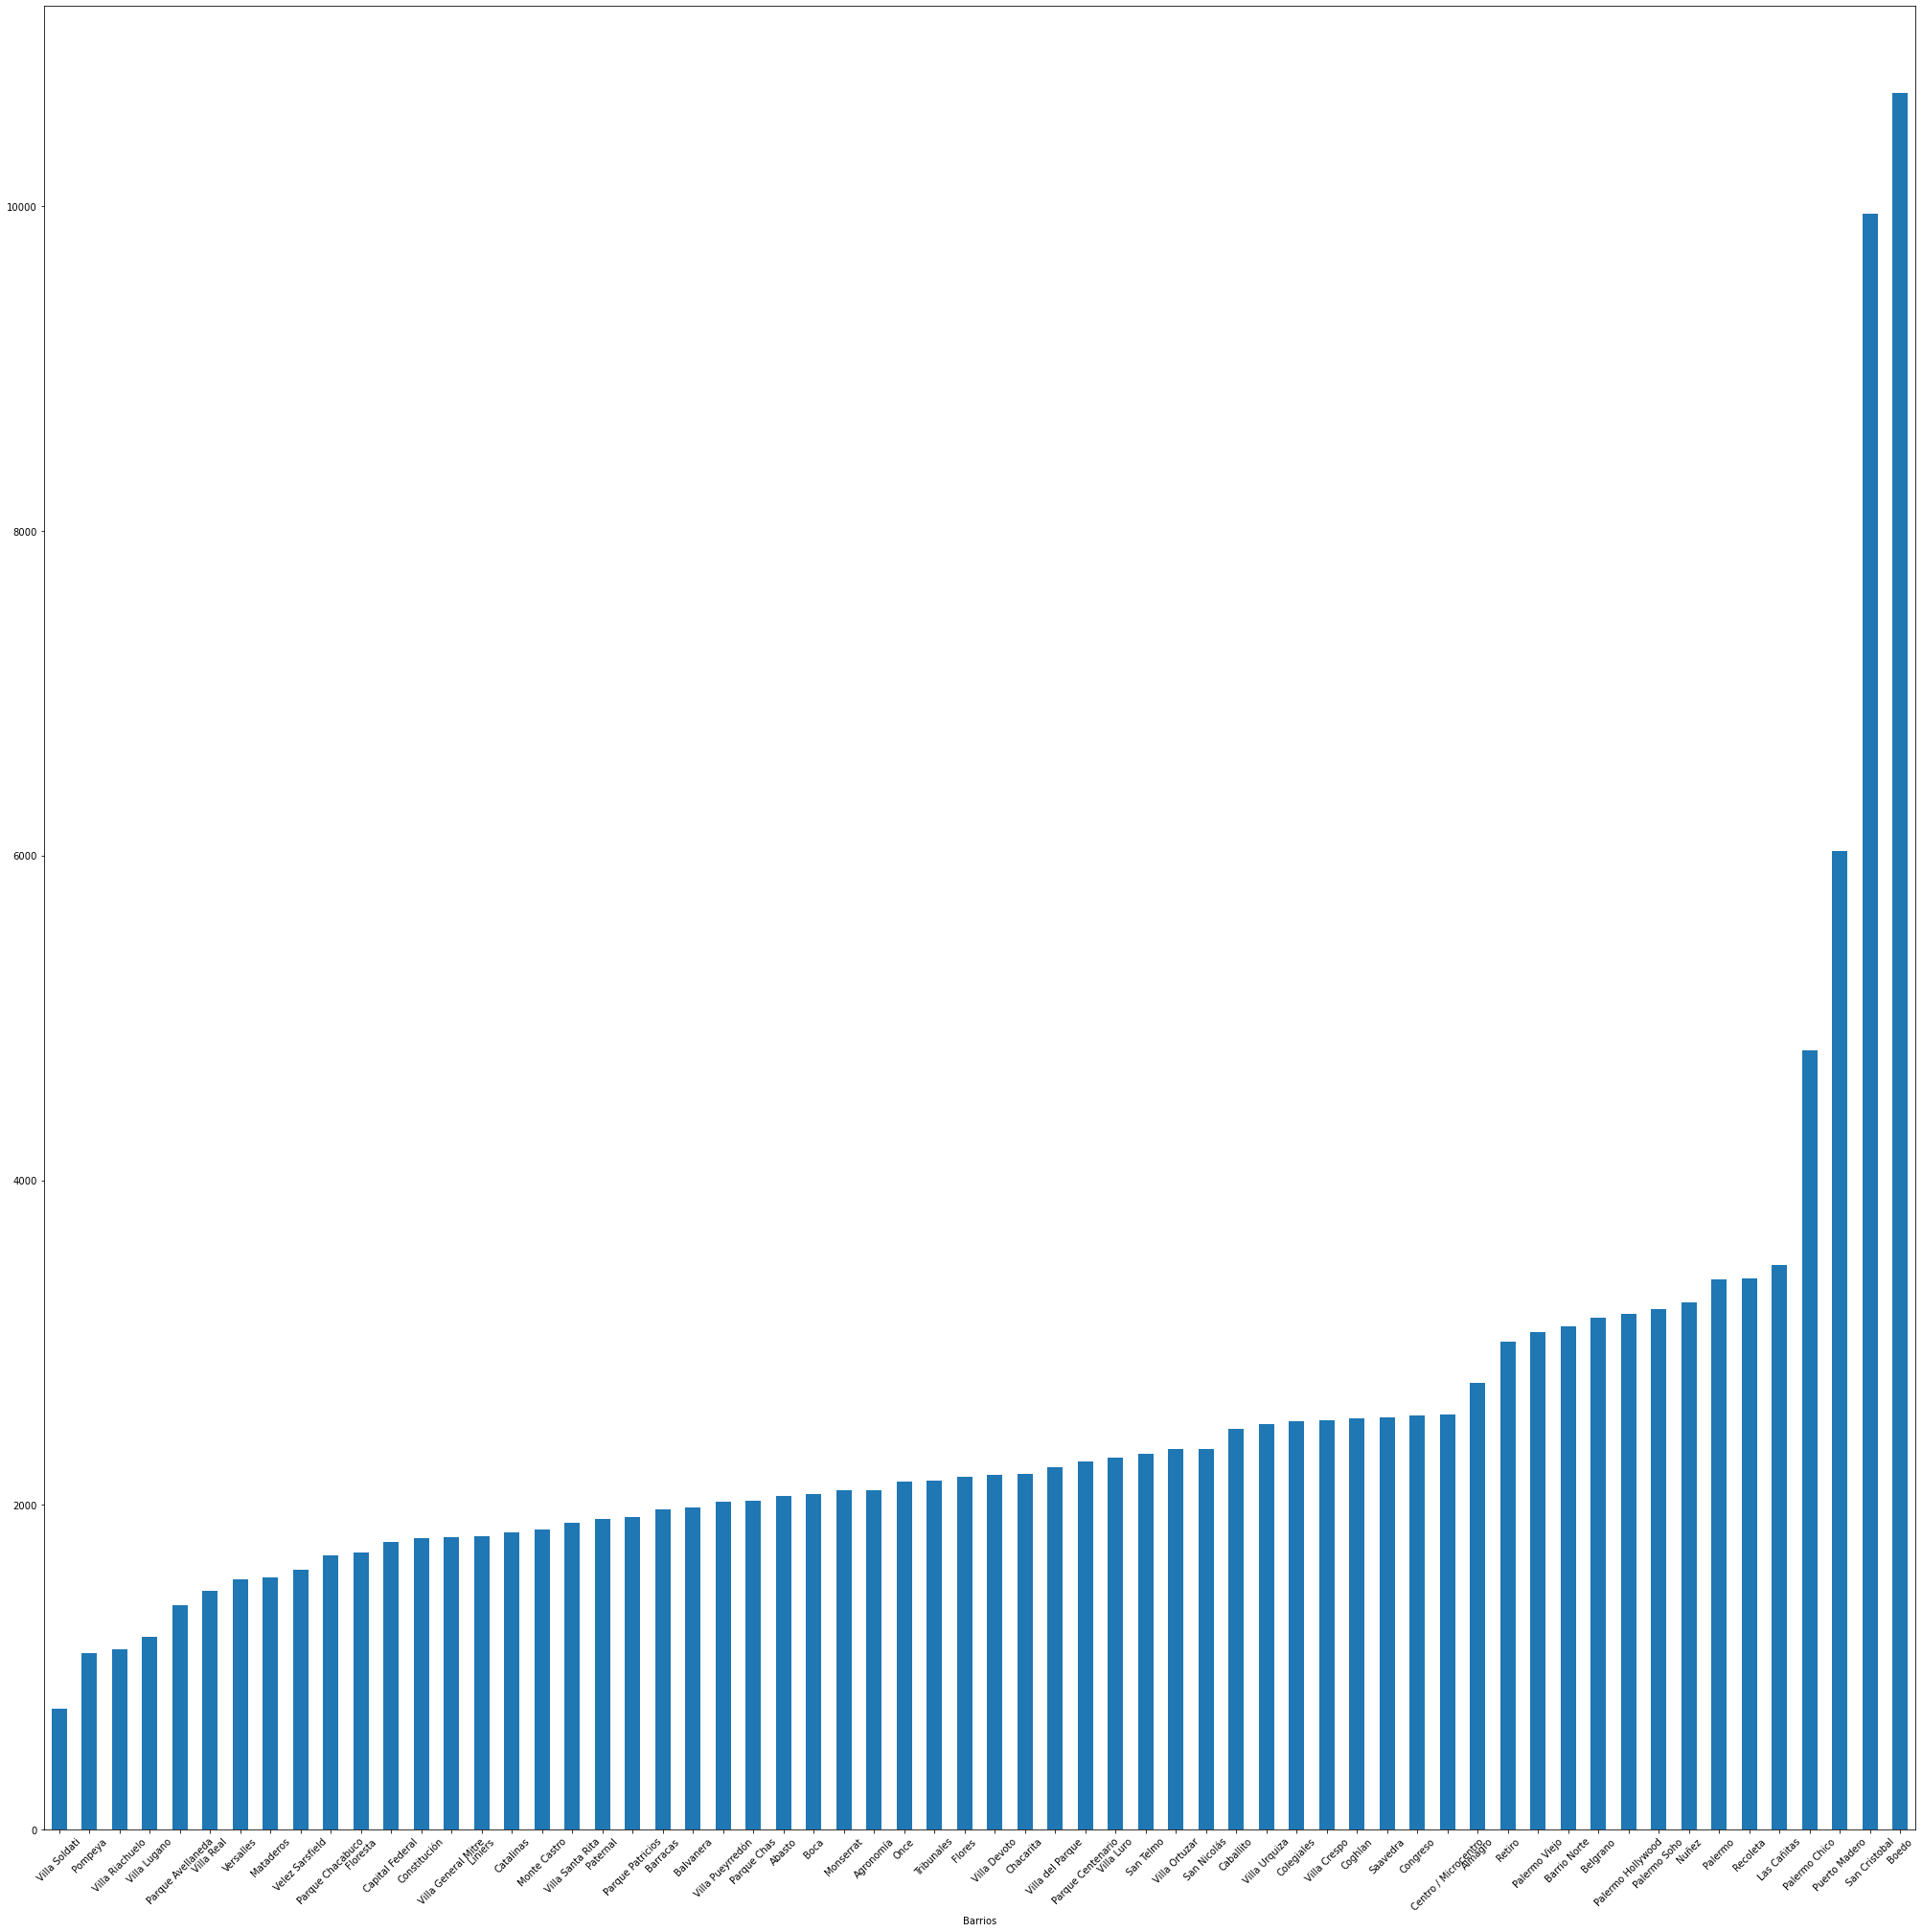

In [10]:
#graficamos el dataframe sin limpiar
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2.groupby('place_name').price_usd_per_m2.mean()
serie_y.sort_values().plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

<AxesSubplot:xlabel='Barrios'>

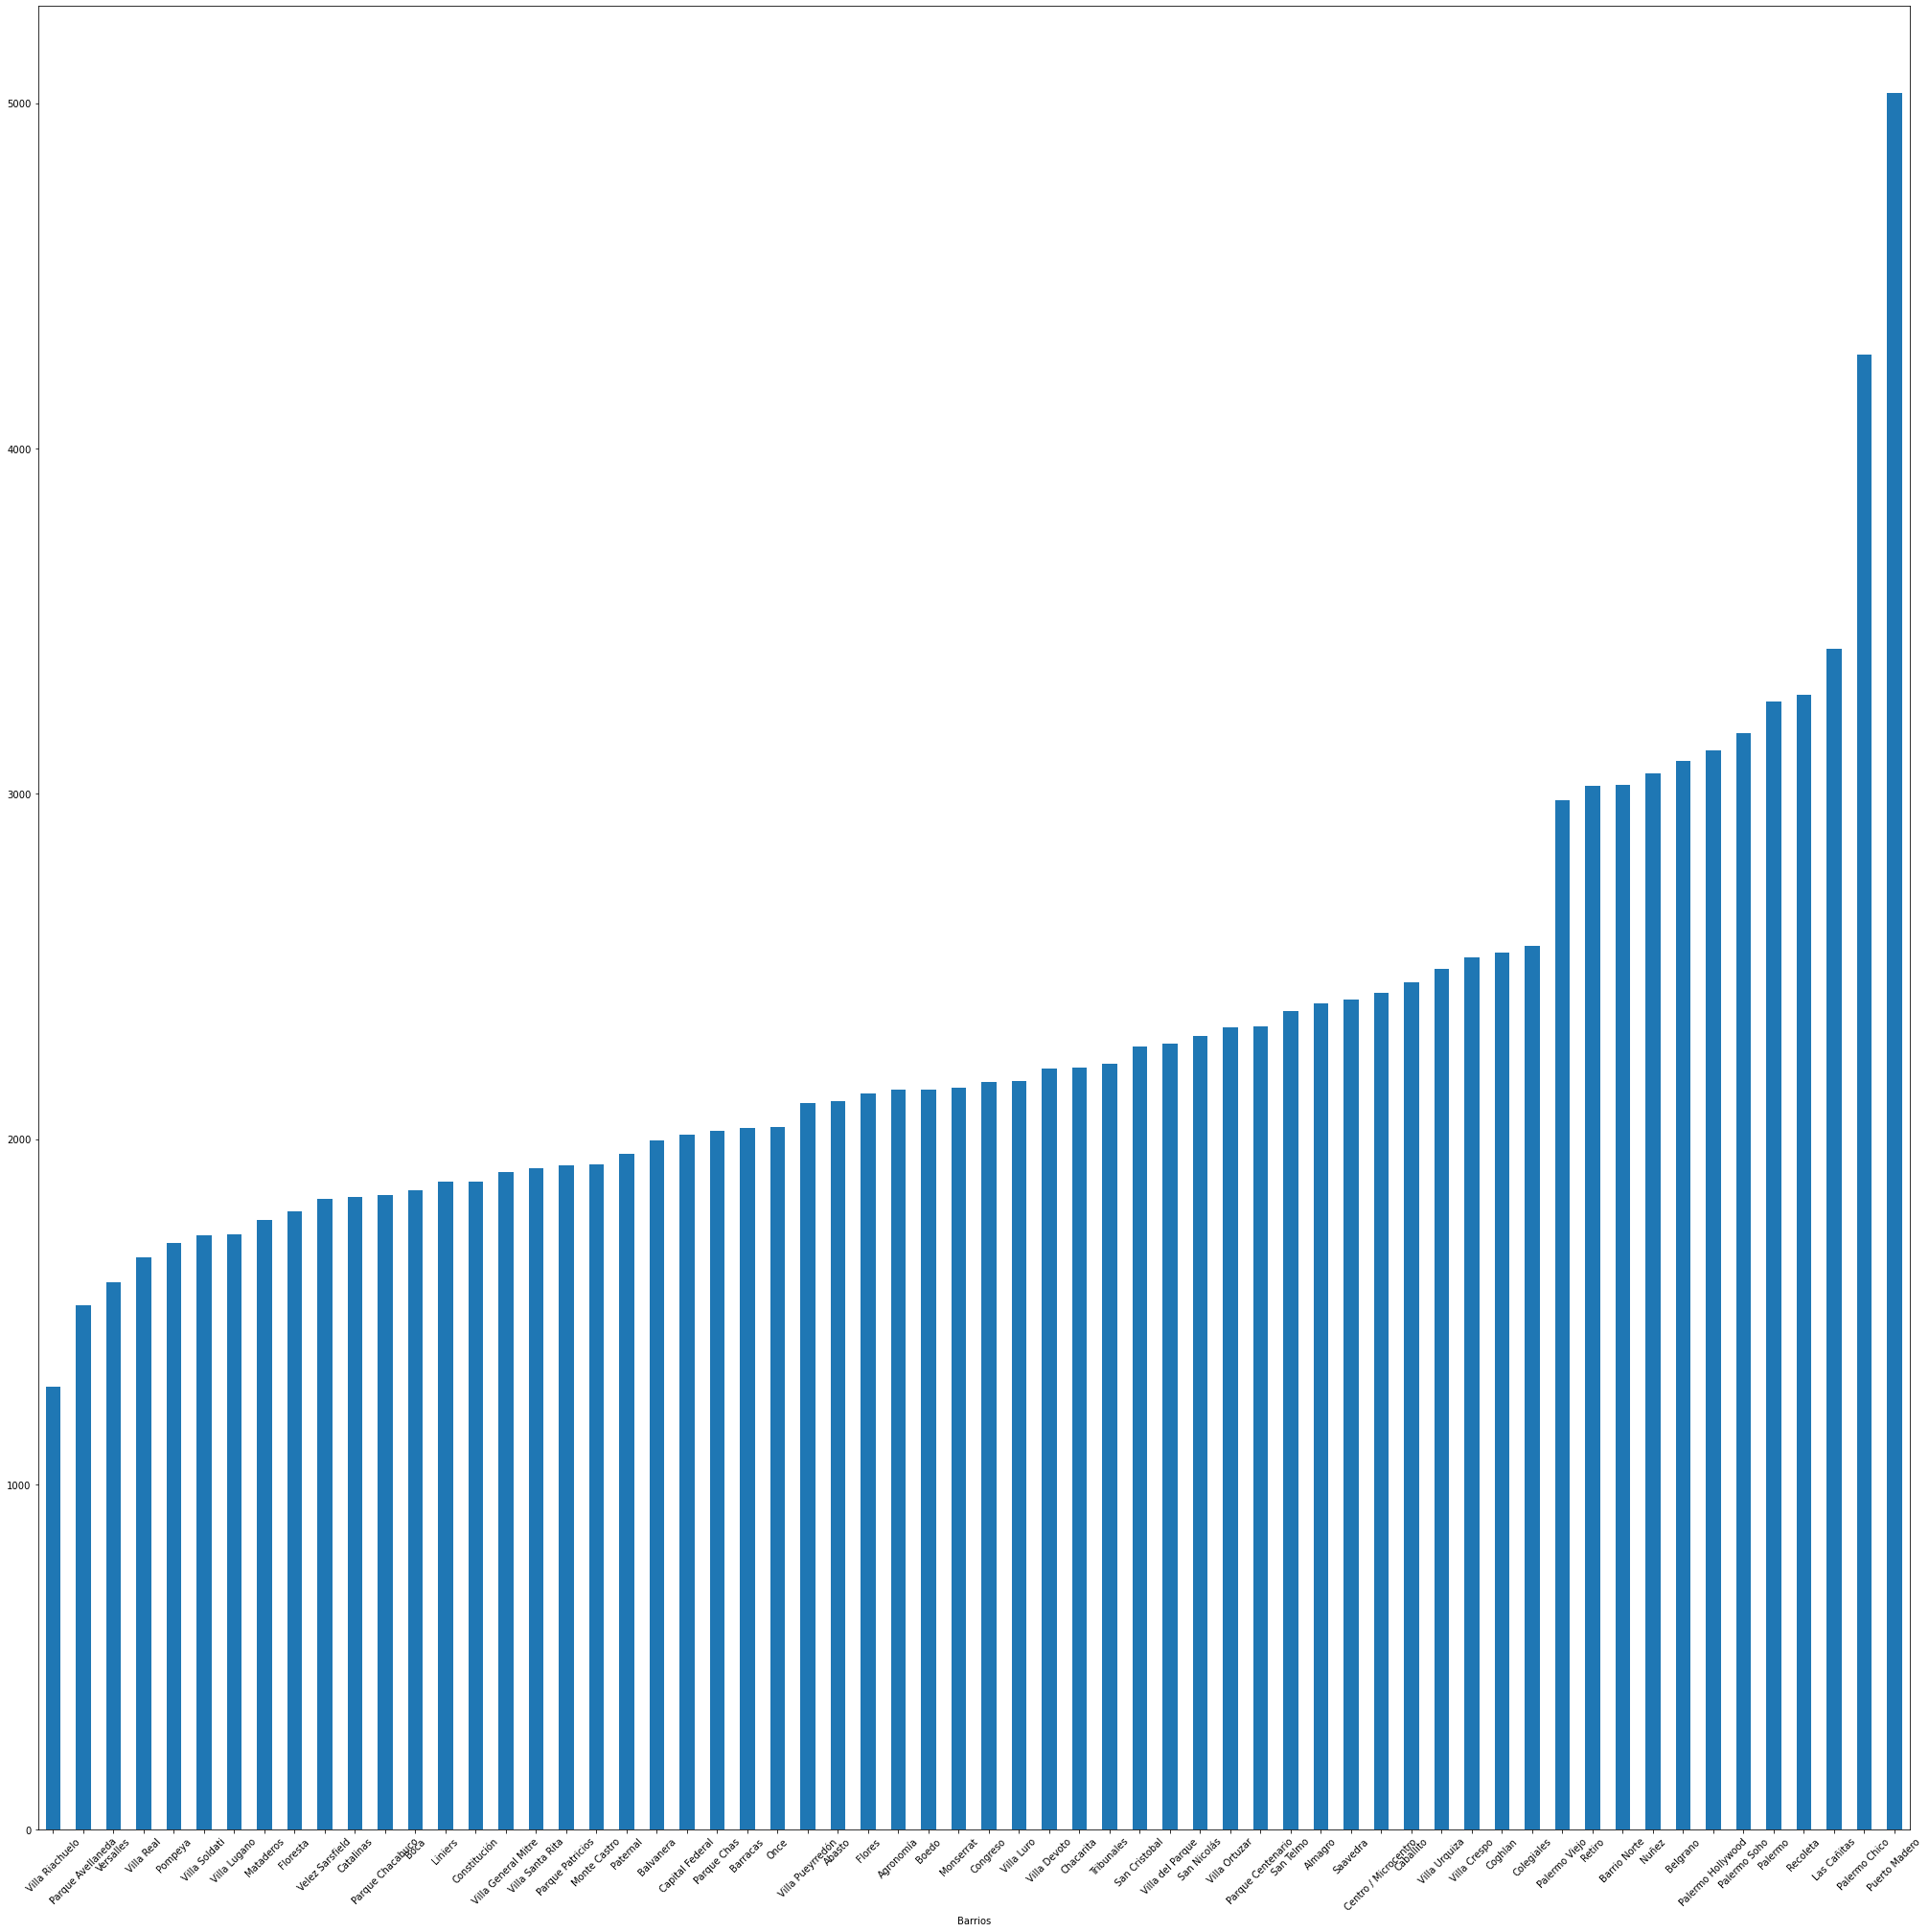

In [11]:
##graficamos el dataframe limpio
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2[removed_outliers].groupby('place_name').price_usd_per_m2.mean()
serie_y.sort_values().plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

In [12]:
#revisamos cuales otras columnas faltan por datos
propiedades_capital2.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2                  0
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
price_usd_per_m2_mean             0
dtype: int64

In [45]:
#observamos que el campo un campo valioso para determinar el precio es el area de la propiedad
#en este caso no podriamos hacer un promedio, procedemos a removerla surface_total_in_m2
propiedades_capital3=propiedades_capital2.dropna(axis=0,how='any',subset=['surface_total_in_m2'])
propiedades_capital3.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1169
lat-lon                        7866
lat                            7866
lon                            7866
price                          2990
currency                       2990
price_aprox_local_currency     2990
price_aprox_usd                2990
surface_total_in_m2               0
surface_covered_in_m2          1553
price_usd_per_m2                  0
price_per_m2                   4120
floor                         24985
rooms                         15304
expenses                      20270
properati_url                     0
description                       0
title                             0
image_thumbnail                 353
price_usd_per_m2_mean             0
dtype: int64

In [14]:
#funcion para extraer del campo description, el numero de ambientes o habitaciones
def limpieza_description(text):
    try:
        txt="(\d+(?=\s+dorm)|\d(?=\s+amb)|\d(?=\s+hab))"
        txt=txt.lower()
        x=int(re.findall(txt, text)[0])
        
    except IndexError:
        x="1"
    return(x) 

In [15]:
#creamos un df nuevo solo con casas y departamentos para poder limpiar la descripcion
propiedades_capital_casas_dptops=propiedades_capital3.loc[(propiedades_capital3.property_type=="apartment")|(propiedades_capital3.property_type=="house")|(propiedades_capital3.property_type=="PH")]


In [16]:
#creamos el patron REGEX para la busqueda de palabras como "dorm","amb" y "hab". Este patron buscará el primer numero 
#que consiga antes de alguna de esas palabras
propiedades_capital_casas_dptops['rooms_fill']=propiedades_capital_casas_dptops['description'].apply(lambda x: limpieza_description(x))

<ipython-input-16-877365f9f26a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
#propiedades_capital_casas_dptops[['rooms','rooms_fill','description']].sample(5)
propiedades_capital_casas_dptops[['rooms','rooms_fill','description']].sample(5)

,rooms,rooms_fill,description
27046,NaN,1,"Departamento 48m² con Cable, Capital Federal, ..."
25369,NaN,3,"Es un edificio en pozo con piscina, SUM, gimna..."
20438,NaN,3,Edificio de doble frente en excelente ubicació...
19280,NaN,1,RBA Excelente Dto de 1 amb a la Vta super lumi...
25955,NaN,4,"Presentamos Star Álvarez Thomas,una torre resi..."


In [18]:
#propiedades_capital_casas_dptops.iloc[]

In [19]:
texto="VENTA DEPARTAMENTO 2 AMBIENTES EN SAAVEDRAEdificio Queen VI -  García del Río 4037Excelentes accesos.Preventa en pozo. Departamentos de 1, 2 y 3 ambientes. Forma de pago: 100% al momento del boleto.Cercano a principales accesos y medios de transporte.Próximo a la estación Saavedra del ferrocarril Mitre y a la Av. Balbín.Forma de pago: 100% al boletoPara más información contáctenos: Sucursal Núñez: Sucursal Olivos: Sucursal Villa Adelina: Sucursal Carapachay: Sucursal Florid"

In [20]:

propiedades_capital3.property_type.value_counts()

apartment    22580
house         1495
PH            1297
store         1065
Name: property_type, dtype: int64

In [21]:
propiedades_capital_casas_dptops.property_type.value_counts()

apartment    22580
house         1495
PH            1297
Name: property_type, dtype: int64

In [22]:
texto.lower()

'venta departamento 2 ambientes en saavedraedificio queen vi -  garcía del río 4037excelentes accesos.preventa en pozo. departamentos de 1, 2 y 3 ambientes. forma de pago: 100% al momento del boleto.cercano a principales accesos y medios de transporte.próximo a la estación saavedra del ferrocarril mitre y a la av. balbín.forma de pago: 100% al boletopara más información contáctenos: sucursal núñez: sucursal olivos: sucursal villa adelina: sucursal carapachay: sucursal florid'

In [23]:
texto

'VENTA DEPARTAMENTO 2 AMBIENTES EN SAAVEDRAEdificio Queen VI -  García del Río 4037Excelentes accesos.Preventa en pozo. Departamentos de 1, 2 y 3 ambientes. Forma de pago: 100% al momento del boleto.Cercano a principales accesos y medios de transporte.Próximo a la estación Saavedra del ferrocarril Mitre y a la Av. Balbín.Forma de pago: 100% al boletoPara más información contáctenos: Sucursal Núñez: Sucursal Olivos: Sucursal Villa Adelina: Sucursal Carapachay: Sucursal Florid'

In [49]:
propiedades_capital4=propiedades_capital3[['place_name','price_usd_per_m2']]
propiedades_capital4.head()

,place_name,price_usd_per_m2
0,Mataderos,1127.272727
1,Mataderos,1309.090909
3,Belgrano,3066.666667
4,Belgrano,3000.000000
5,Palermo Soho,2234.000000


In [51]:
propiedades_capital4.value_counts().head(50)

place_name         price_usd_per_m2
Belgrano           3153.981976         437
Palermo            3388.451498         349
Capital Federal    1772.903875         294
Villa Urquiza      2495.288265         266
Caballito          2467.686974         200
Almagro            2749.102521         168
Villa Crespo       2522.508111         139
Recoleta           3392.858919         115
Barrio Norte       3098.248857         112
Floresta           1706.740147          81
Palermo Soho       3206.125554          75
Puerto Madero      6029.687303          69
Nuñez              3246.570606          65
Palermo Hollywood  3174.218748          54
San Telmo          2314.992619          49
Boedo              1233.333333          48
Flores             2170.858377          44
Palermo Chico      4797.326384          38
San Cristobal      9952.388570          35
Once               2145.366555          33
Boedo              10697.513056         32
Balvanera          1982.249390          31
Saavedra          

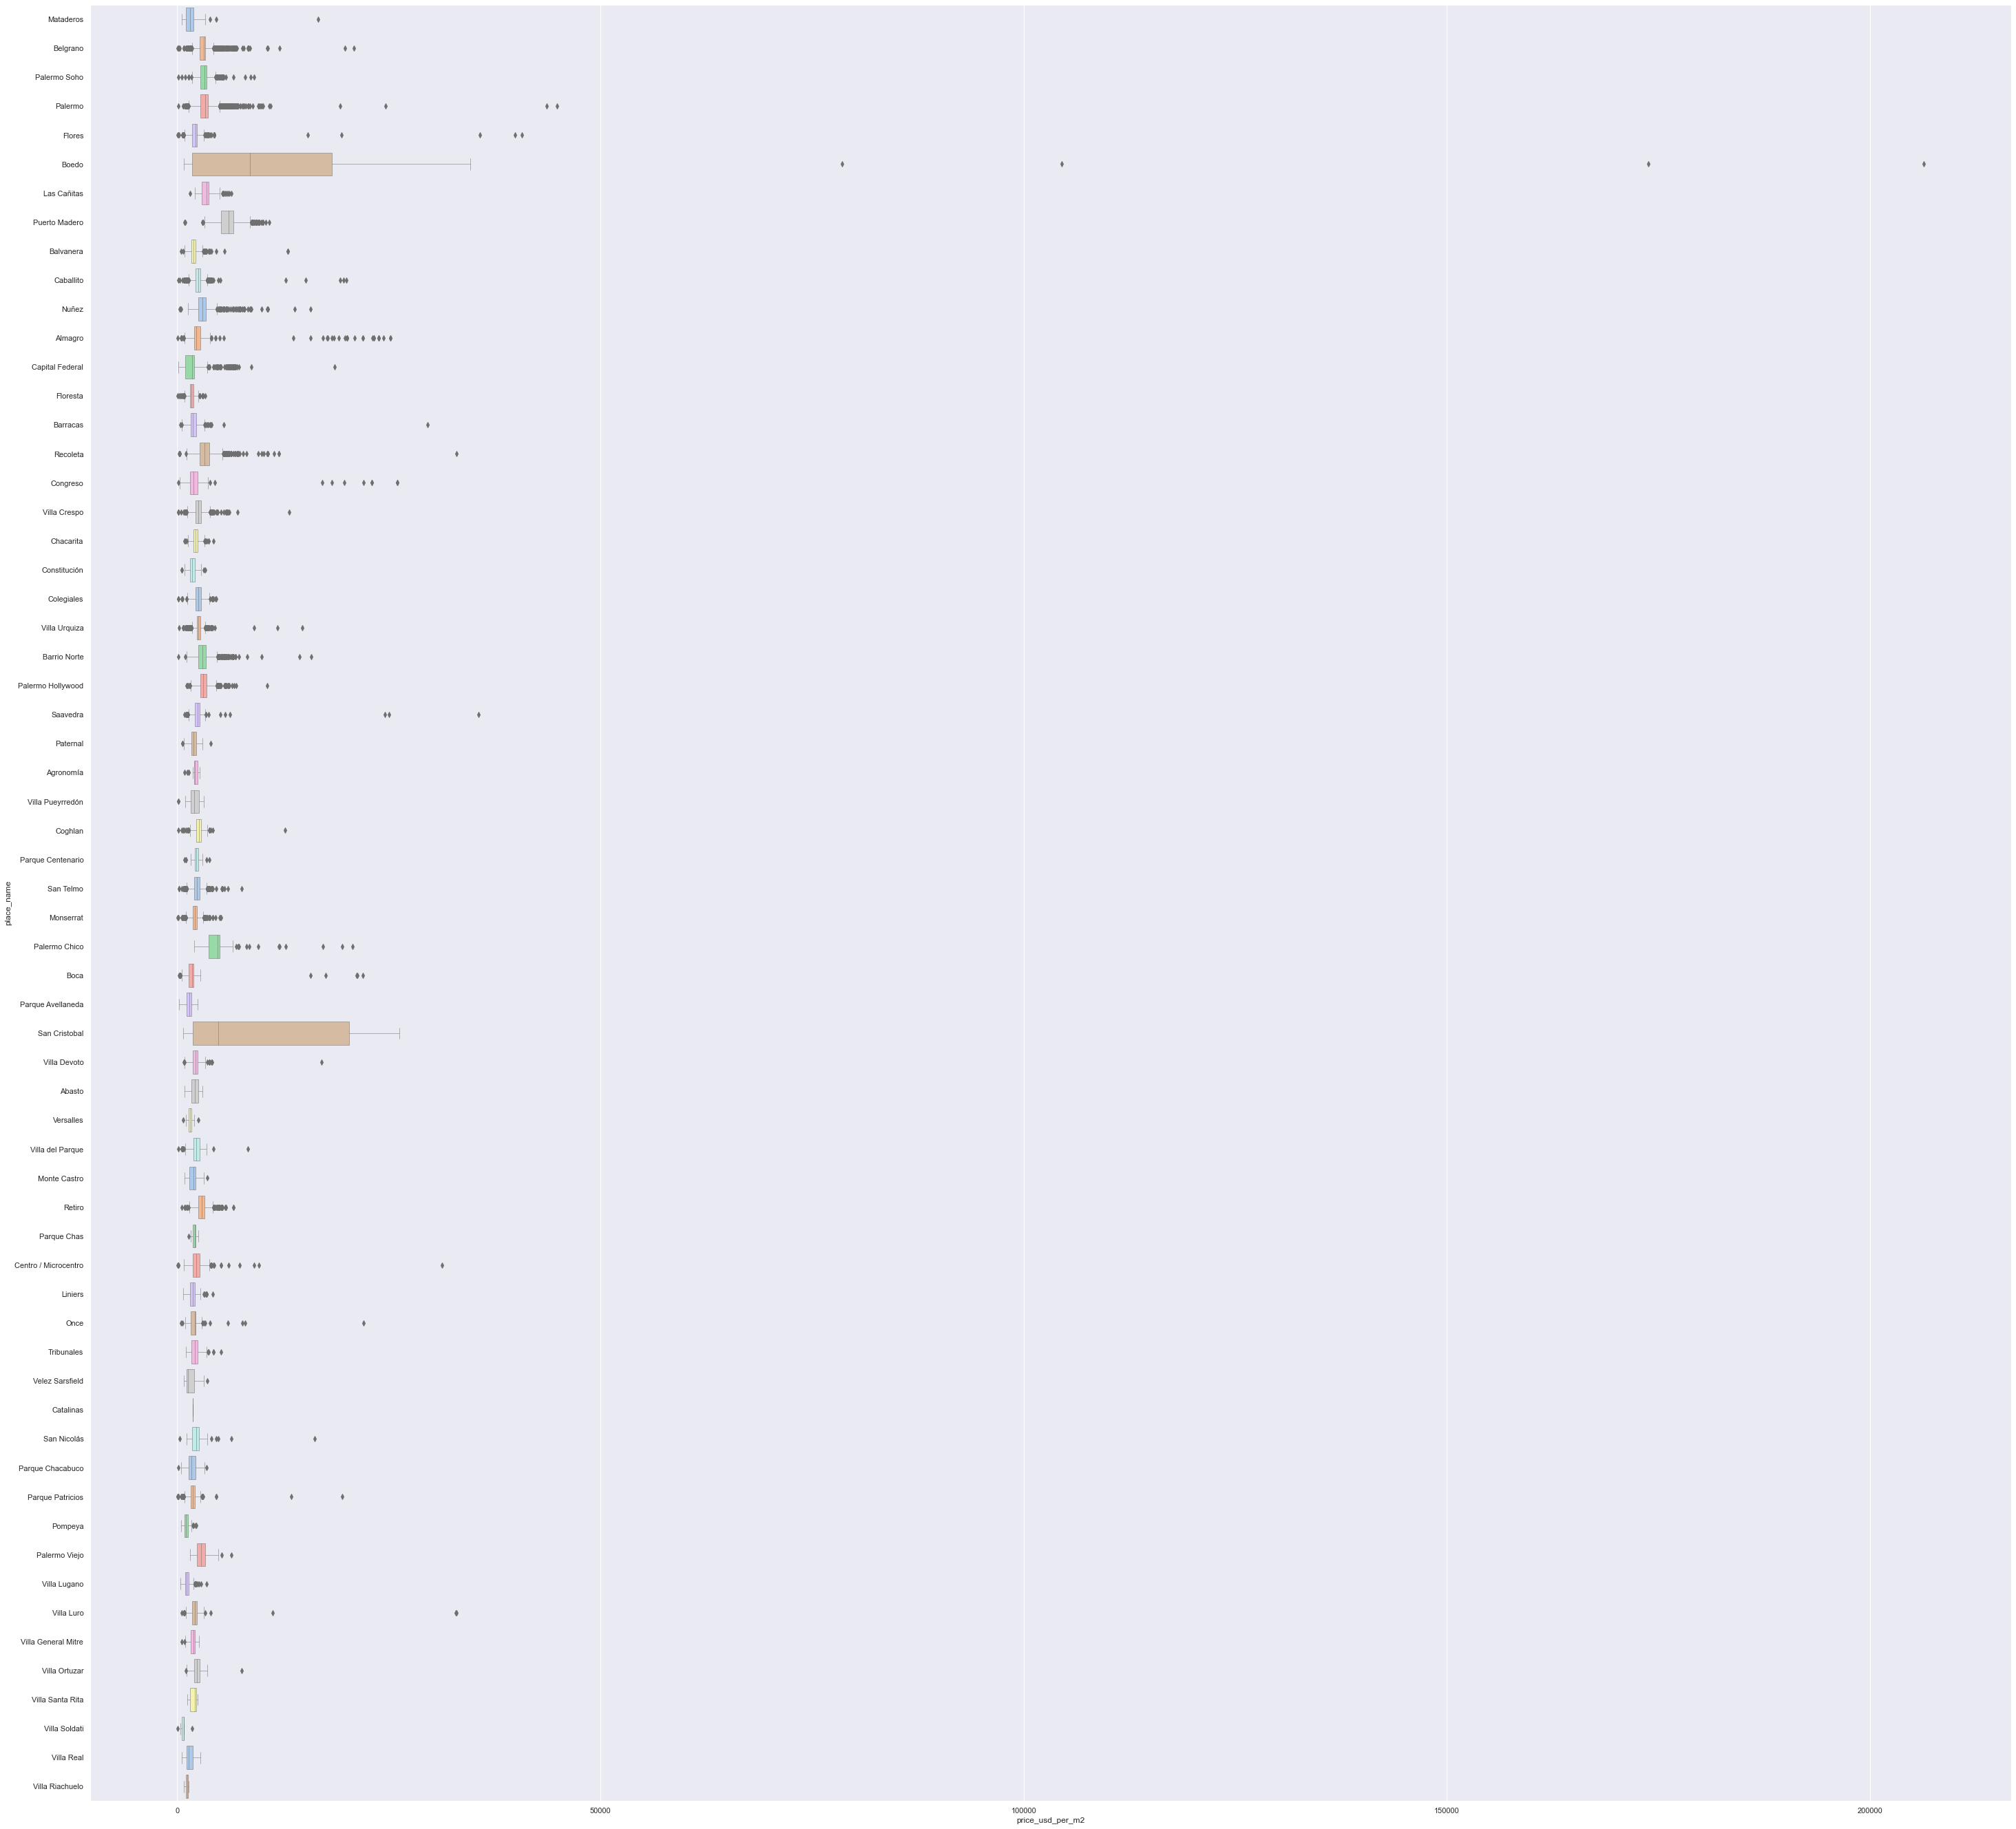

In [90]:
import seaborn as sns
from matplotlib import pyplot as plt 
fig, ax = plt.subplots(figsize =(50, 48))
sns.set(style="darkgrid")
sns.boxplot(x=propiedades_capital4["price_usd_per_m2"], y=propiedades_capital4["place_name"], orient="h",  
            linewidth=0.5, palette='pastel')

plt.show()

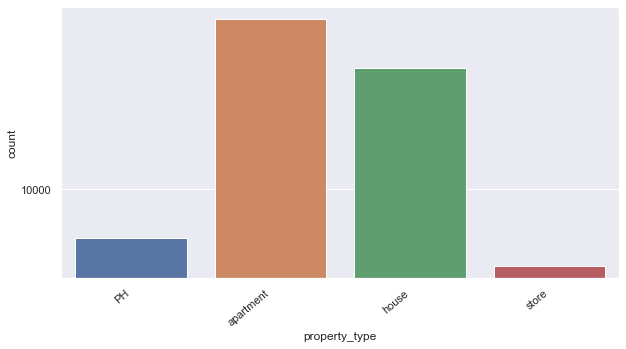

In [104]:
from matplotlib.ticker import ScalarFormatter
plt.figure(figsize=(10,5))
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
ax = sns.countplot(data = propiedades, x = "property_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")


plt.show()

<AxesSubplot:>

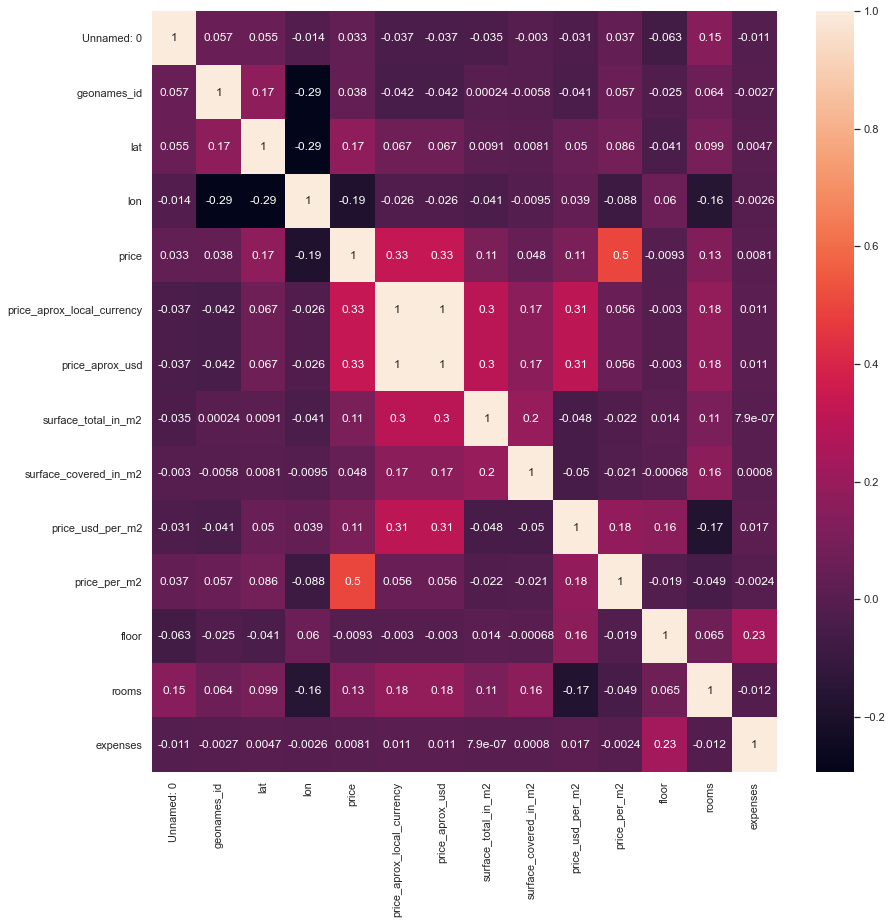

In [114]:
fig =plt.subplots(figsize=(14,14))
sns.heatmap(propiedades.corr(), annot=True)

In [138]:
#Columnas con pocos valores
for i in range(propiedades.shape[1]):
    num=len(pd.unique(propiedades.iloc[:,i]))
    porcentaje=float(num)/propiedades.shape[0]*100
    print("%d, %d, %.1f%%"%(i,num,porcentaje))


0, 121220, 100.0%
1, 1, 0.0%
2, 4, 0.0%
3, 1061, 0.9%
4, 1164, 1.0%
5, 1, 0.0%
6, 28, 0.0%
7, 647, 0.5%
8, 47204, 38.9%
9, 46496, 38.4%
10, 46523, 38.4%
11, 9747, 8.0%
12, 5, 0.0%
13, 10365, 8.6%
14, 10365, 8.6%
15, 1688, 1.4%
16, 996, 0.8%
17, 25568, 21.1%
18, 25186, 20.8%
19, 183, 0.2%
20, 32, 0.0%
21, 983, 0.8%
22, 121220, 100.0%
23, 104056, 85.8%
24, 72705, 60.0%
25, 114390, 94.4%


In [118]:
#Filas con datos duplicados
datos_duplicados = propiedades.duplicated()
print(datos_duplicados.any())
print(propiedades[datos_duplicados])

False
Empty DataFrame
Columns: [Unnamed: 0, operation, property_type, place_name, place_with_parent_names, country_name, state_name, geonames_id, lat-lon, lat, lon, price, currency, price_aprox_local_currency, price_aprox_usd, surface_total_in_m2, surface_covered_in_m2, price_usd_per_m2, price_per_m2, floor, rooms, expenses, properati_url, description, title, image_thumbnail]
Index: []

[0 rows x 26 columns]


In [119]:
#Eliminamos filas con datos duplicados
print(propiedades.shape)
propiedades.drop_duplicates(inplace=True)
print(propiedades.shape)

(121220, 26)
(121220, 26)


In [124]:
dptos=propiedades[propiedades["property_type"]=="Departamento"]
phs=propiedades[propiedades["property_type"]=="PH"]
casas=propiedades[propiedades["property_type"]=="Casa"]

In [125]:
dptos= dptos[(dptos.price <= 392500.0) & (dptos.price >=65000.0) ]
phs=phs[(phs.price <= 428500.0) & (phs.price >=75000.0) ]
casas=casas[(casas.price <= 706000.0) & (casas.price >=110000.0) ]

ValueError: min() arg is an empty sequence

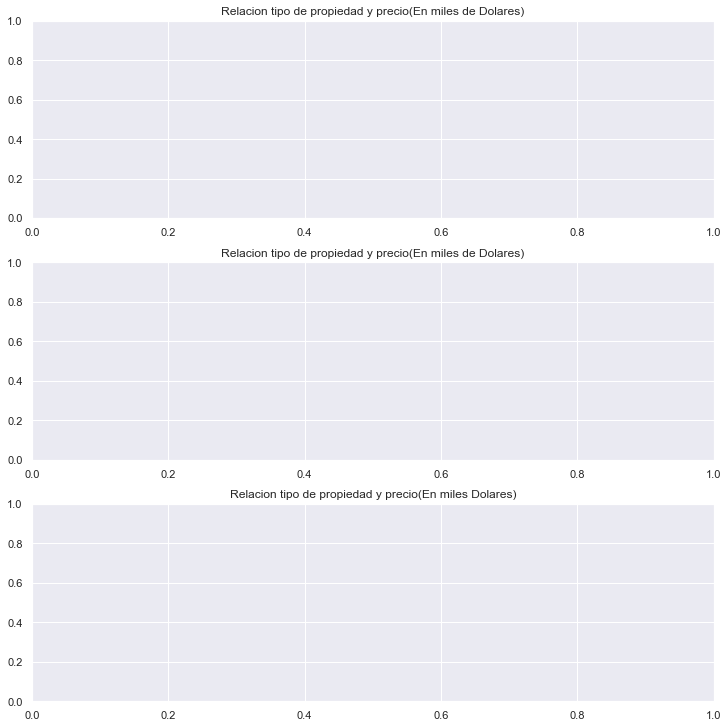

In [142]:

figure,(ax1,ax2,ax3) = plt.subplots(3,constrained_layout=True,figsize=(10,10))
ax1.set_title("Relacion tipo de propiedad y precio(En miles de Dolares)")
ax2.set_title("Relacion tipo de propiedad y precio(En miles de Dolares)")
ax3.set_title("Relacion tipo de propiedad y precio(En miles Dolares)")
sns.boxplot(data=dptos,x="price",y="property_type",ax=ax1)
sns.boxplot(data=phs,x="price",y="property_type",ax=ax2)
sns.boxplot(data=casas,x="price",y="property_type",ax=ax3)
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()